<a href="https://colab.research.google.com/github/kavithachitriki/OCRProject/blob/main/KerasRetinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [1]:
!git clone https://github.com/fizyr/keras-retinanet

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 8.73 MiB/s, done.
Resolving deltas: 100% (4200/4200), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

#https://drive.google.com/drive/folders/12a6KHwcQfIkrKRkQtEtnGjjKZ5ja25-8?usp=sharing

Mounted at /content/drive


In [3]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp37-cp37m-linux_x86_64.whl size=168020 sha256=0bb23f45b1f8aa44e64eb3711981868d33e74a19ea75ad77aafe0d3fe89ca5ec
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=23b9720acb0185ee90c658dccb33c5d569dc293396f00a0c3dc53e4ffa5f8d9b
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [28]:
from google.colab import files
uploaded = files.upload()

Saving labels.csv to labels.csv


In [5]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/keras_retinanet
creating build/temp.linux-x86_64-3.7/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -

In [6]:
!pip install gdown
!pip install tensorflow.gpu

     |████████████████████████████████| 394.3MB 39kB/s 


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr,preprocess_image,resize_image
from keras_retinanet.utils.visualization import draw_box,draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted',font_scale=1.5)

rcParams['figure.figsize'] = 22,10

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [10]:
os.makedirs("snapshots",exist_ok=True)

In [11]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5

Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:01, 149MB/s]


In [29]:
df = pd.read_csv('labels.csv')

dataset=dict()
dataset["image_name"]=list()
dataset["x_min"]=list()
dataset["y_min"]=list()
dataset["x_max"]=list()
dataset["y_max"]=list()
dataset["class_name"]=list()

width=1
height=1
counter=1

from csv import reader
# open file in read mode
with open('labels.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        # row variable is a list that represents a row in csv
        dataset["class_name"].append(row[0])
        img=Image.open(row[5]).convert('RGB')
        img.save(f'pantest{counter}.jpeg','JPEG')
        dataset["image_name"].append(f'pantest{counter}.jpeg')
        counter=counter+1
        x_min=int(row[1])
        y_min=int(row[2])
        x_max=int(row[1])+int(row[3])
        y_max=int(row[2])+int(row[4])
        dataset["x_min"].append( x_min* width)
        dataset["y_min"].append( y_min* height)
        dataset["x_max"].append( x_max * width)
        dataset["y_max"].append( y_max * height)  





In [13]:
print(dataset["image_name"])
  

['pantest1.jpeg', 'pantest2.jpeg', 'pantest3.jpeg', 'pantest4.jpeg', 'pantest5.jpeg', 'pantest6.jpeg', 'pantest7.jpeg', 'pantest8.jpeg', 'pantest9.jpeg', 'pantest10.jpeg', 'pantest11.jpeg', 'pantest12.jpeg', 'pantest13.jpeg', 'pantest14.jpeg', 'pantest15.jpeg', 'pantest16.jpeg', 'pantest17.jpeg']


In [30]:
df=pd.DataFrame(dataset)
df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,pantest1.jpeg,128,160,147,182,check_mark
1,pantest2.jpeg,164,256,181,273,check_mark
2,pantest3.jpeg,152,235,172,253,check_mark
3,pantest4.jpeg,175,241,193,259,check_mark
4,pantest5.jpeg,139,246,158,263,check_mark


In [15]:
def show_image_objects(image_row):
  img_path = image_row.image_name
  print(image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max)
  box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  draw_box(draw, box, color=(255, 255, 0))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

128 160 147 182


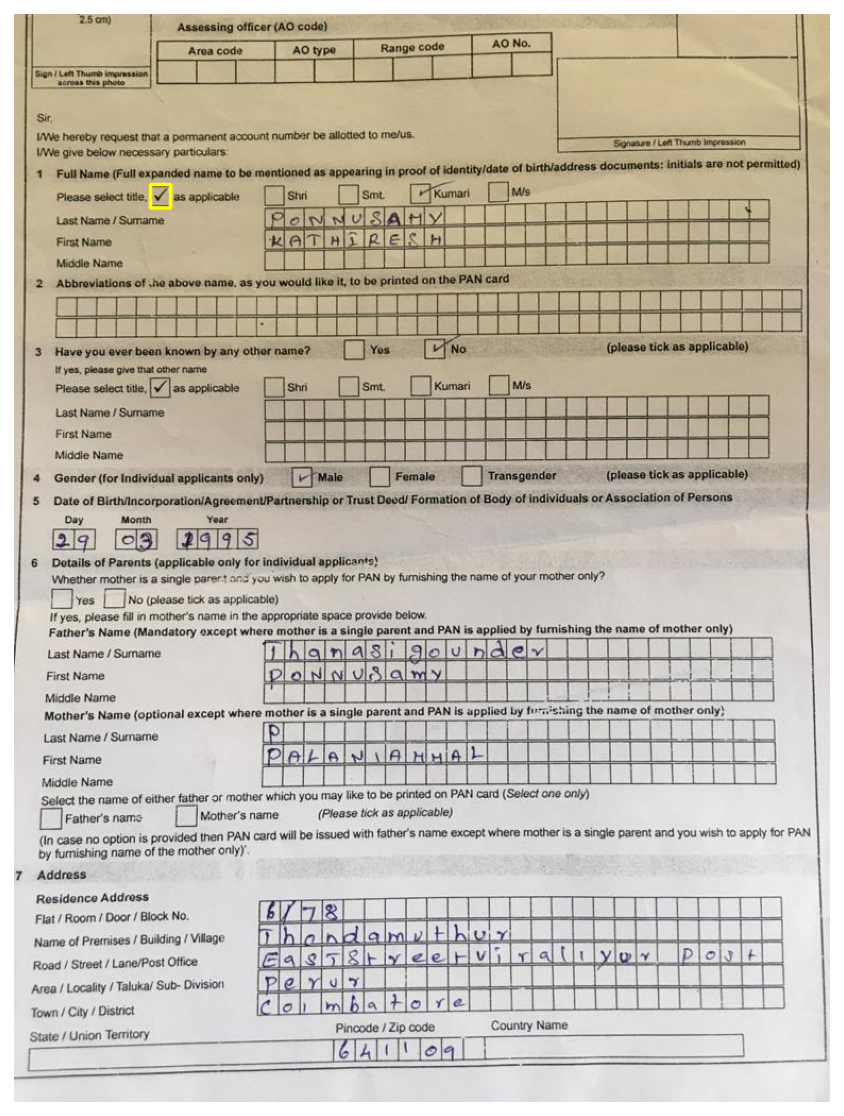

In [31]:

show_image_objects(df.iloc[0])



In [32]:
train_df,test_df=train_test_split(df,test_size=0.2,random_state=RANDOM_SEED)

In [33]:
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
183,pantest184.jpeg,175,241,193,259,check_mark
38,pantest39.jpeg,96,236,121,255,check_mark
24,pantest25.jpeg,183,265,200,283,check_mark
142,pantest143.jpeg,143,244,166,264,check_mark
141,pantest142.jpeg,151,233,173,250,check_mark


In [34]:
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
82,pantest83.jpeg,164,256,181,273,check_mark
15,pantest16.jpeg,172,243,191,261,check_mark
111,pantest112.jpeg,138,233,162,250,check_mark
177,pantest178.jpeg,138,233,162,250,check_mark
76,pantest77.jpeg,143,244,166,264,check_mark


In [35]:
ANNOTATIONS_FILE="annotations.csv"
CLASSES_FILE="classes.csv"

In [36]:
train_df.to_csv(ANNOTATIONS_FILE,index=False,header=None)

In [37]:
classes=set(['check_mark'])

with open(CLASSES_FILE,'w') as f:
  for i,line in enumerate(sorted(classes)):
    f.write('{}, {}\n'.format(line,i))

In [38]:
!head annotations.csv

pantest184.jpeg,175,241,193,259,check_mark
pantest39.jpeg,96,236,121,255,check_mark
pantest25.jpeg,183,265,200,283,check_mark
pantest143.jpeg,143,244,166,264,check_mark
pantest142.jpeg,151,233,173,250,check_mark
pantest30.jpeg,138,233,162,250,check_mark
pantest20.jpeg,175,241,193,259,check_mark
pantest170.jpeg,158,228,178,247,check_mark
pantest128.jpeg,138,233,162,250,check_mark
pantest119.jpeg,139,246,158,263,check_mark


In [39]:
!head classes.csv

check_mark, 0


In [25]:
#Training
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [41]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --lr 1e-3 --batch-size 8 --steps 10 --epochs 10 csv annotations.csv classes.csv

2021-03-26 08:35:40.095484: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Creating model, this may take a second...
2021-03-26 08:35:42.248402: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-26 08:35:42.249438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-26 08:35:42.260923: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-26 08:35:42.260990: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cedc3c4d1fac): /proc/driver/nvidia/version does not exist
2021-03-26 08:35:42.261525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to u

In [42]:
!ls snapshots

_pretrained_model.h5  resnet50_csv_04.h5  resnet50_csv_08.h5
resnet50_csv_01.h5    resnet50_csv_05.h5  resnet50_csv_09.h5
resnet50_csv_02.h5    resnet50_csv_06.h5  resnet50_csv_10.h5
resnet50_csv_03.h5    resnet50_csv_07.h5


In [43]:
model_path=os.path.join('snapshots',sorted(os.listdir('snapshots'),reverse=True)[0])

In [44]:
model_path

'snapshots/resnet50_csv_10.h5'

In [45]:
model=models.load_model(model_path,backbone_name='resnet50')

In [46]:
model=models.convert_model(model)

In [47]:
labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

In [48]:
labels_to_names

{0: 'check_mark'}

In [67]:
THRES_SCORE = 0.5
def show_detected_objects(image_row):
  img_path = image_row.image_name
  true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  image=preprocess_image(image)
  image,scale=resize_image(image)
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image,axis=0))
  boxes=boxes/scale
  draw_box(draw, true_box, color=(218, 45, 45))
  #draw detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
       break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    print("box drawn")
    caption = "{}{:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)
    print("object detected")
    print(b[0])
    print(b[1])
    print(b[2])
    print(b[3])
    d_box = [b[0], b[1], b[2],b[3]]
    draw_box(draw, d_box, color=(255, 255, 0))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    return d_box
  #plt.figure(figsize=(15, 15))
  




In [50]:
test_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
82,pantest83.jpeg,164,256,181,273,check_mark
15,pantest16.jpeg,172,243,191,261,check_mark
111,pantest112.jpeg,138,233,162,250,check_mark
177,pantest178.jpeg,138,233,162,250,check_mark
76,pantest77.jpeg,143,244,166,264,check_mark


box drawn
object detected
137
230
162
251


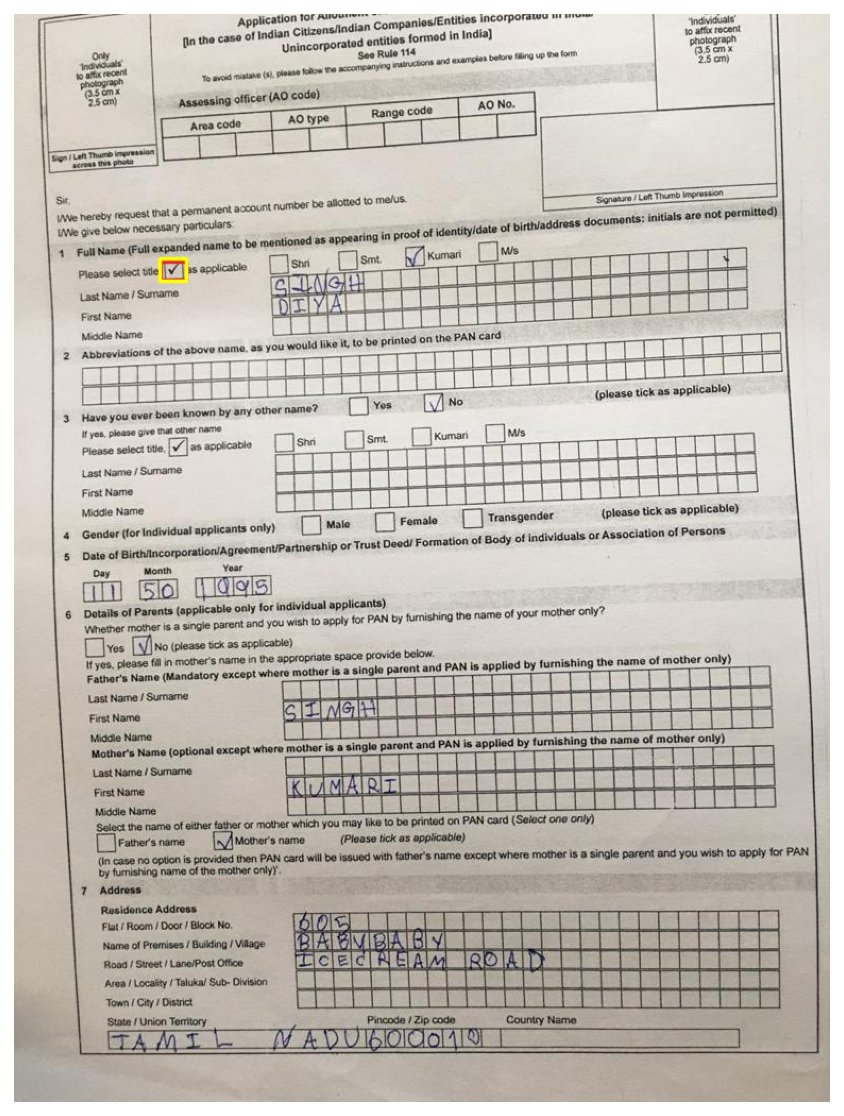

In [72]:
testimage=test_df.iloc[3]
x_check_min,x_check_max,y_check_min,y_check_max=show_detected_objects(testimage)
  

In [55]:
#Saving model in h5 format
saved_model=model.save("ocr_retinanet_model.h5")

In [59]:
reconstructed_model=models.load_model("ocr_retinanet_model.h5",backbone_name='resnet50')

In [73]:
import cv2
from google.colab.patches import cv2_imshow
import imutils

def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_letters(img):
    letters = []
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        # ypred = model.predict(thresh)
        #ypred = LB.inverse_transform(ypred)
        #[x] = ypred
        #letters.append(x)
        cv2_imshow(image)
    return image




In [2]:

#Bounding Boxes for Father Last Name

#Father Last Name
testimage='pan3.jpeg'
fl_x_min=int(x_check_min)+93
fl_y_min=int(y_check_min)+385
fl_x_max=int(x_check_max)+518
fl_y_max=int(y_check_max)+389

img_path = testimage.image_name
image = img=cv2.imread(img_path)

fatherLastName = image[fl_y_min:fl_y_max, fl_x_min:fl_x_max]
image=get_letters(fatherLastName)



NameError: ignored

# New Section